In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Validate endogenous volumes against those from VP2030

In [2]:
scenario = 'base'
manual = True
%matplotlib inline

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_zones')

In [6]:
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in segments][::2]

In [56]:
# Load endogenously generated volumes
new = stepmodel.read_zippedpickles(model_path + 'de_volumes')

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.55s/it]


In [57]:
segments = [s for s in segments if s in new.volumes.columns]
purposes = [s.split('_')[0] for s in segments][::2]

In [58]:
new.volumes.reset_index(inplace=True)

In [59]:
# Sum of new volumes
vol_sum = new.volumes.loc[new.volumes['origin']!=new.volumes['destination']
                         ].set_index(['origin', 'destination']).sum(axis=1).rename('vol')
vol_sum.sum() / 1e9

42.37961901986574

In [60]:
# Sum of new volumes (inner-zonal)
new.volumes.loc[new.volumes['origin']==new.volumes['destination'], segments].sum().sum() / 1e9

34.44477820986338

In [61]:
# Difference in OD sets
od_new = set([(o,d) for o,d in zip(new.volumes['origin'], new.volumes['destination'])])
len(od_new)

21095649

In [13]:
# Load old volumes
volumes_file = 'de_volumes_exo'
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
try:
    v = stepmodel.read_zippedpickles(model_path.replace(scenario, 'base') + volumes_file)
    # Rename columns from VP2030 to match the model's demand segments
    sm.volumes = v.volumes.rename(columns={
        c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
        for c in v.volumes.columns if c.startswith('Fz')
    })
    # Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
    accompany_no_car_share = 101 / 1530
    accompany_car_share = 5569 / 30292
    sm.volumes['accompany'+car_segment_dict['0']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
    sm.volumes['accompany'+car_segment_dict['1']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)
except FileNotFoundError:
    sm.volumes = pd.DataFrame(columns=new.volumes.columns)

In [14]:
# Length of the OD set
od_vol = set([(o,d) for o,d in zip(sm.volumes['origin'], sm.volumes['destination'])])
len(od_vol)

0

In [15]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_all_trips_MiD2017.csv')
# Rename modes and purposes
mode_dict_mid = {1: 'rail_short', 2: 'rail_long',
                 3: 'coach', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])
mid2017['segment'] = mid2017['purpose_model'] + mid2017['car_avail'].map(
    {1: '_car', 0: '_no_car', 9: '_no_car'})
mid2017 = mid2017[['mode_model', 'purpose_model', 'segment', 'origin', 'destination']]

In [16]:
# Load VP2030 data for validation
'''vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])
# Aggregate by purpose
vp2017 = vp2017.groupby('segment', axis=1).sum().rename(columns=vp_purpose_dict)
vp2017.reset_index(inplace=True)'''
vp2017 = pd.DataFrame(columns=list(vp_purpose_dict.values()) + ['origin', 'destination'])

In [17]:
# Load distances
distances = pd.read_csv(output_path + 'distances_centroids.csv')
distances = distances.set_index(['origin', 'destination'])

## Validation

### Total volumes

In [62]:
# Inner- and inter-zonal volumes by segment
seg_df = pd.DataFrame()
seg_df['exo_inner'] = sm.volumes.loc[sm.volumes['origin']==sm.volumes['destination'],
                                     segments].sum()
seg_df['exo_inter'] = sm.volumes.loc[sm.volumes['origin']!=sm.volumes['destination'],
                                     segments].sum()
seg_df['endo_inner'] = new.volumes.loc[new.volumes['origin']==new.volumes['destination'],
                                       segments].sum()
seg_df['endo_inter'] = new.volumes.loc[new.volumes['origin']!=new.volumes['destination'],
                                       segments].sum()
# Add MiD volumes
scaler = new.volumes[segments].sum().sum() / len(mid2017)
seg_df['MiD_inner'] = mid2017.loc[mid2017['origin']==mid2017['destination']
                                 ].groupby('segment').count()['origin'].fillna(0) * scaler
seg_df['MiD_inter'] = mid2017.loc[mid2017['origin']!=mid2017['destination']
                                 ].groupby('segment').count()['origin'].fillna(0) * scaler

In [63]:
# Ratio of total endogenous volumes to scaled MiD volumes
(seg_df['endo_inner'] + seg_df['endo_inter']) / (seg_df['MiD_inner'] + seg_df['MiD_inter'])

commuting_no_car      0.979993
commuting_car         1.280052
business_no_car       0.782518
business_car          0.861923
education_no_car      1.833913
education_car         0.945310
buy/execute_no_car    1.867285
buy/execute_car       0.834080
leisure_no_car        1.927884
leisure_car           0.913993
accompany_no_car      2.351403
accompany_car         1.030823
dtype: float64

<Axes: >

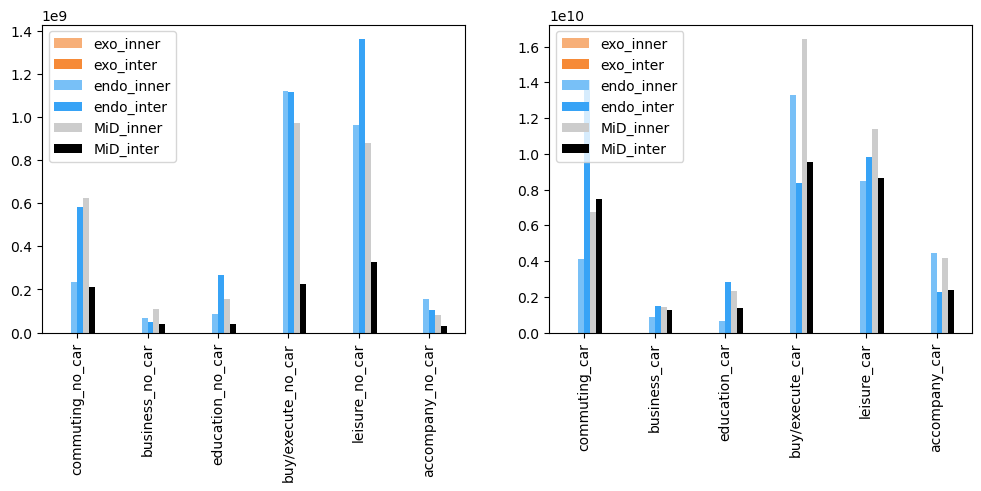

In [64]:
# Compare inner- and inter-zonal volumes by segment
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
seg_df.loc[[s for s in segments if '_no_car' in s]].plot.bar(
    legend=True, color=['#f7af78', '#f68a37', '#78c0f7', '#37a3f6', '#cccccc', '#000000'], ax=ax[0])
seg_df.loc[[s for s in segments if not '_no_car' in s]].plot.bar(
    legend=True, color=['#f7af78', '#f68a37', '#78c0f7', '#37a3f6', '#cccccc', '#000000'], ax=ax[1])

In [65]:
# Share of inner-zonal trips in endogenous volumes
np.round(seg_df['endo_inner'] / (seg_df['endo_inter'] + seg_df['endo_inner']), 3)

commuting_no_car      0.288
commuting_car         0.225
business_no_car       0.590
business_car          0.361
education_no_car      0.247
education_car         0.184
buy/execute_no_car    0.501
buy/execute_car       0.614
leisure_no_car        0.414
leisure_car           0.464
accompany_no_car      0.596
accompany_car         0.664
dtype: float64

### Distance distribution

In [40]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 200, 300, 500, 1000]
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [41]:
# Assign distances to volumes
for df in [new.volumes, sm.volumes, vp2017, mid2017]:
    if not 'bins' in df.columns:
        df['dist'] = df.set_index(['origin', 'destination']).index.map(distances.to_dict()['length'])
        df.loc[df['origin']==df['destination'], 'dist'] = 1
        df['bins'] = pd.cut(df['dist'].fillna(bins[-1]-1), bins=bins, labels=labels)

In [42]:
# Sum up volumes of the model and exogenous data
vol_df = pd.DataFrame()
for car in car_segment_dict.values():
    segs = [s for s in segments if s.endswith(car)]
    vol_df['endo'+car] = new.volumes.groupby('bins').sum()[segs].sum(axis=1)
    vol_df['exo'+car] = sm.volumes.groupby('bins').sum()[segs].sum(axis=1)
vol_df['endo'] = new.volumes.groupby('bins').sum()[segments].sum(axis=1)
vol_df['exo'] = sm.volumes.groupby('bins').sum()[segments].sum(axis=1)

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_12920\729869234.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_df['endo'+car] = new.volumes.groupby('bins').sum()[segs].sum(axis=1)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_12920\729869234.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_df['exo'+car] = sm.volumes.groupby('bins').sum()[segs].sum(axis=1)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_12920\729869234.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tr

<Axes: xlabel='bins'>

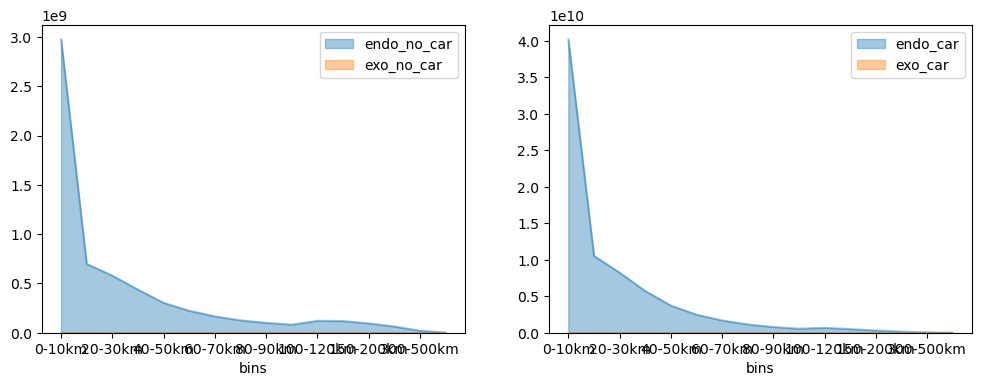

In [43]:
# plot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
vol_df[['endo_no_car', 'exo_no_car']].plot(kind='area', stacked=False, alpha=.4, ax=ax[0])
vol_df[['endo_car', 'exo_car']].plot(kind='area', stacked=False, alpha=.4, ax=ax[1])

<Axes: xlabel='bins'>

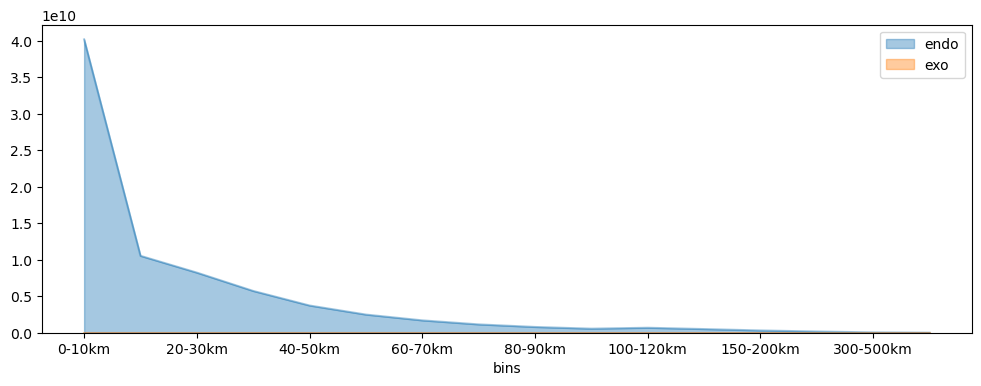

In [44]:
# plot total
vol_df[['endo', 'exo']].plot(kind='area', stacked=False, alpha=.4, figsize=(12,4))

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_12920\3899248758.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_df['endo_'+p] = new.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_12920\3899248758.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_df['exo_'+p] = sm.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_12920\3899248758.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

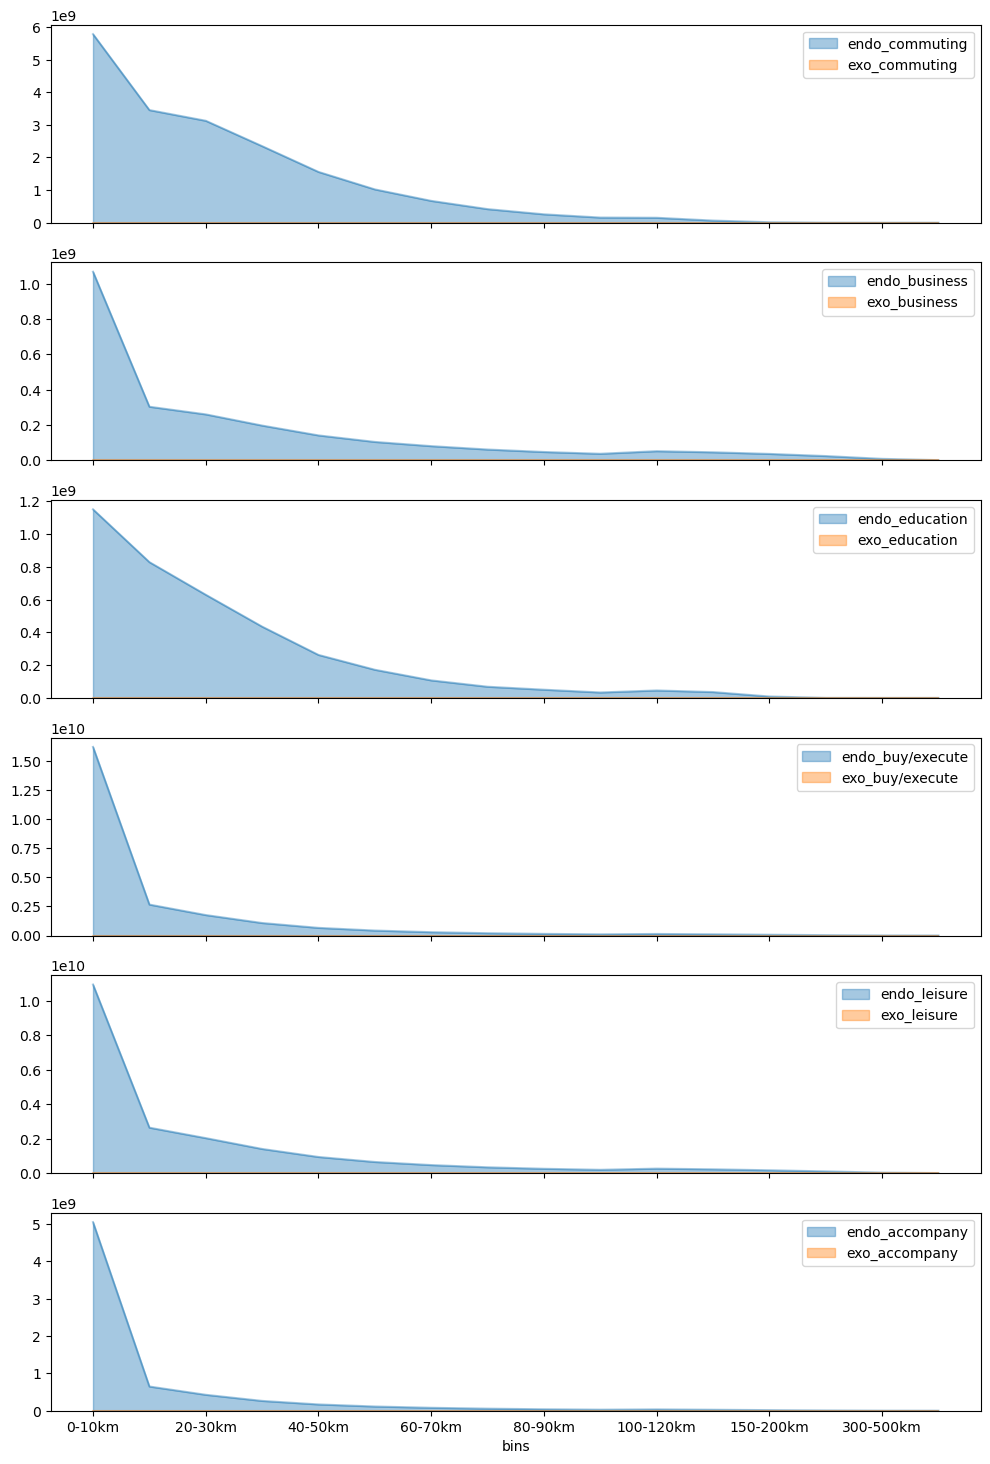

In [45]:
# plot by purpose
fig, ax = plt.subplots(ncols=1, nrows=len(purposes), figsize=(12,len(purposes)*3), sharex='all')
i = 0
for p in purposes:
    vol_df['endo_'+p] = new.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
    vol_df['exo_'+p] = sm.volumes.groupby('bins').sum()[[s for s in segments if p in s]].sum(axis=1)
    vol_df[['endo_'+p, 'exo_'+p]].plot(kind='area', stacked=False, alpha=.4, ax=ax[i])
    i += 1

In [46]:
# Scale to VP2030 levels
vol_df['VP2030'] = vp2017.loc[vp2017['bins'].notna()].groupby('bins').sum()[
    ['commuting', 'education', 'buy/execute', 'business', 'leisure']
].sum(axis=1)
if vol_df['VP2030'].sum() > 0:
    vol_df['endo'] /= vol_df['endo'].mean() / vol_df['VP2030'].mean()
    vol_df['exo'] /= vol_df['exo'].mean() / vol_df['VP2030'].mean()

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_12920\3733484385.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_df['VP2030'] = vp2017.loc[vp2017['bins'].notna()].groupby('bins').sum()[


<Axes: xlabel='bins'>

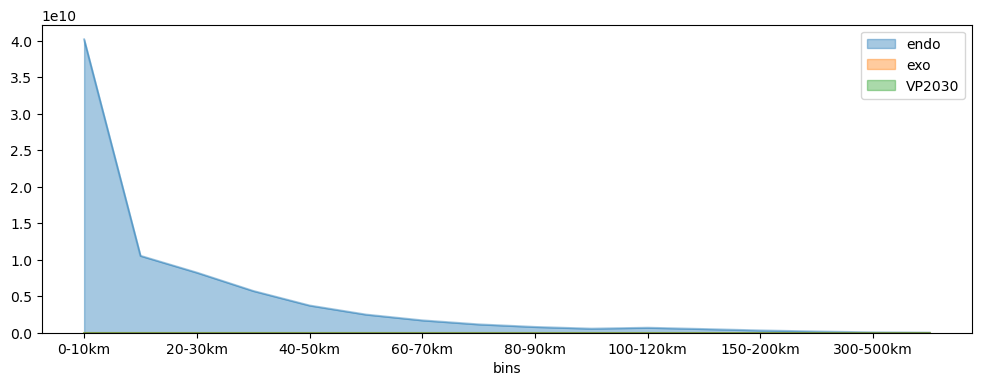

In [47]:
# plot with VP2030
vol_df[[c for c in vol_df.columns if not '_' in c]].plot(
    kind='area', stacked=False, alpha=.4, figsize=(12,4))

In [48]:
# Add MiD2017
vol_df['MiD2017'] = mid2017.groupby('bins').size()
vol_df['MiD2017'] /= vol_df['MiD2017'].mean() / vol_df['endo'].mean()

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_12920\2086935759.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_df['MiD2017'] = mid2017.groupby('bins').size()


<Axes: xlabel='bins'>

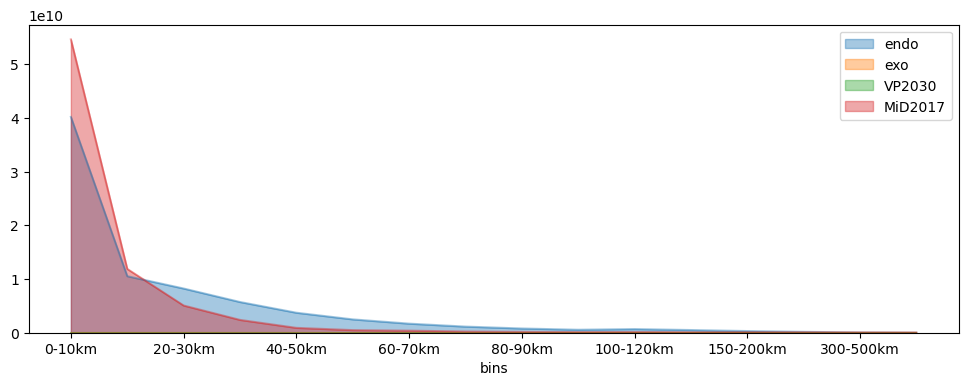

In [49]:
# plot with MiD2017
vol_df[[c for c in vol_df.columns if not '_' in c]].plot(
    kind='area', stacked=False, alpha=.4, figsize=(12,4))